In [79]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [38]:
map_size = 2 #arcminutes
pixel_size = 1/2 #arcseconds

pixel_number = map_size*(60/pixel_size)

x = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
y = np.linspace(-0.5*map_size, 0.5*map_size, int(pixel_number))
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

l = np.arange(30000, dtype=float)
const = 10
index = -0.7

spectrum=const*(l**index)
spectrum[0] = 0

/tmp/ipykernel_11134/319828132.py:15: RuntimeWarning: divide by zero encountered in power
  spectrum=const*(l**index)


In [39]:
fs_scale_factor = np.pi/(pixel_size/60 * np.pi/180)
R_fs = R*fs_scale_factor

spectrum_map = np.zeros(int(R_fs.max())+1)

spectrum_map[0:spectrum.size] = spectrum
print(spectrum)
print(spectrum.size)
print(spectrum_map)
print(len(spectrum_map))

spectrum_map_confined = spectrum_map[(R_fs).astype(int)]

[0.00000000e+00 1.00000000e+01 6.15572207e+00 ... 7.34590866e-03
 7.34573724e-03 7.34556583e-03]
30000
[ 0.         10.          6.15572207 ...  0.          0.
  0.        ]
30548


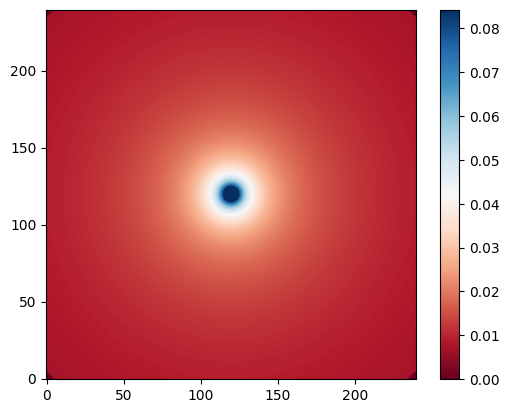

In [50]:
im = plt.imshow(spectrum_map_confined, interpolation='bilinear', origin='lower', cmap='RdBu')
#im.set_clim(0,spectrum_map_confined.max()/4)
cbar = plt.colorbar()
plt.show()

In [67]:
random_noise_2d = np.random.normal(0, 1, (int(pixel_number), int(pixel_number)))
random_noise_2d_fs = np.fft.fft2(random_noise_2d)

signal_map_fs = spectrum_map_confined*random_noise_2d_fs

signal_map = np.fft.ifft2(np.fft.fftshift(signal_map_fs))

In [68]:
#signal_map = np.fft.ifft2(signal_map_fs)
signal_map = signal_map / fs_scale_factor
signal_map = np.real(signal_map)

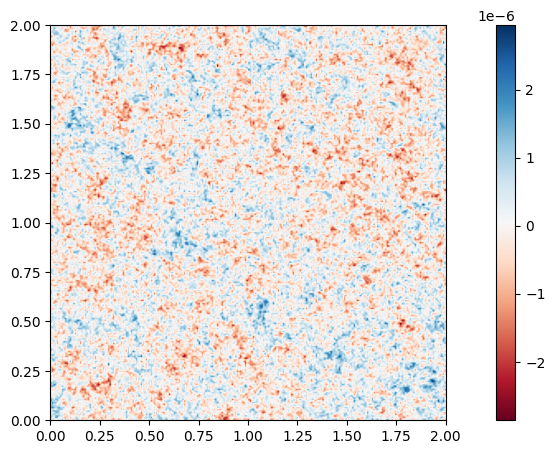

In [83]:
im = plt.imshow(signal_map, origin='lower', interpolation='bilinear', cmap='RdBu')
im.set_clim()
X_width = pixel_number*pixel_size/60.  # horizontal map width in degrees
Y_width = pixel_number*pixel_size/60.  # vertical map width in degrees

plt.gcf().set_size_inches(6,6)
ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
cbar = plt.colorbar(im, cax=cax)
im.set_extent([0,X_width,0,Y_width])
plt.show()

In [72]:
signal_map.max()

np.float64(2.9528164047595824e-06)

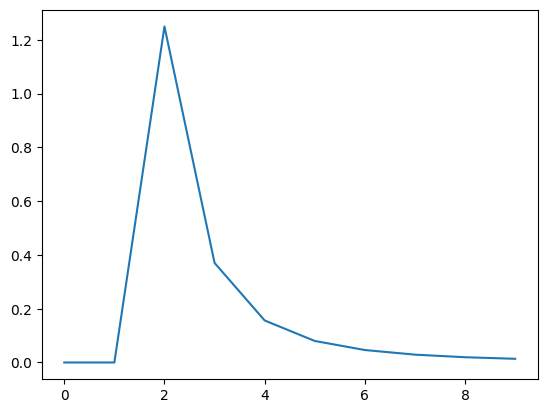

In [15]:
plt.plot(l, spectrum)

In [12]:
3**(-3)*10

0.37037037037037035

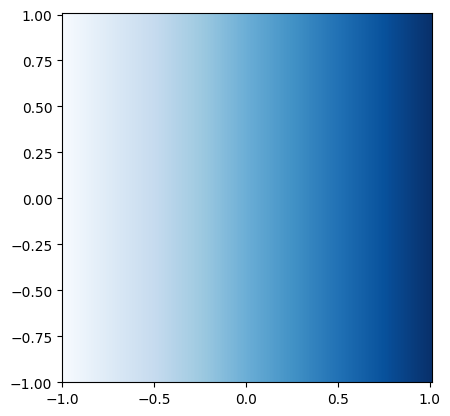

In [9]:
plt.imshow(X, cmap = 'Blues', extent=[min(x),max(x)+0.01,min(x),max(x)+0.01])

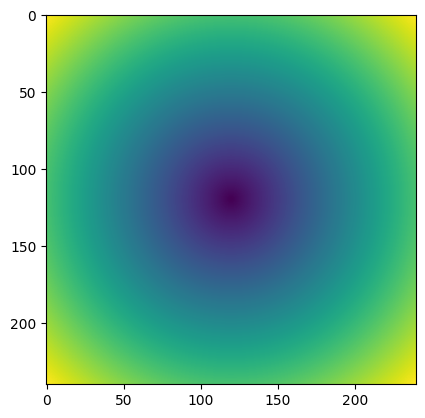

In [15]:
plt.imshow(R)

In [11]:
X

array([[-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       ...,
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ],
       [-1.       , -0.9916318, -0.9832636, ...,  0.9832636,  0.9916318,
         1.       ]])

In [13]:
Y

array([[-1.       , -1.       , -1.       , ..., -1.       , -1.       ,
        -1.       ],
       [-0.9916318, -0.9916318, -0.9916318, ..., -0.9916318, -0.9916318,
        -0.9916318],
       [-0.9832636, -0.9832636, -0.9832636, ..., -0.9832636, -0.9832636,
        -0.9832636],
       ...,
       [ 0.9832636,  0.9832636,  0.9832636, ...,  0.9832636,  0.9832636,
         0.9832636],
       [ 0.9916318,  0.9916318,  0.9916318, ...,  0.9916318,  0.9916318,
         0.9916318],
       [ 1.       ,  1.       ,  1.       , ...,  1.       ,  1.       ,
         1.       ]])